In [1]:
import pandas as pd
import numpy as np
import psycopg2 as psy
from psycopg2 import sql
from sqlalchemy import create_engine
import os
import datetime

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import (plot_confusion_matrix, confusion_matrix, precision_score, recall_score, 
                             accuracy_score, plot_roc_curve, auc)
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

from src.mimic_fxns import connect, insert_data, data_extraction, transform_labs, hot_coding, age_bands, month_transform, data_processing


In [2]:
schema = 'mimiciii'
con_details = {"dbname" : 'mimic', 
               "user" : os.environ['PGSQL_P_USER'], 
               "password" : os.environ['PGSQL_P_PWD'], 
               "host" : 'localhost',
              "options":f'-c search_path={schema}' 
              }    

conn = connect(con_details)

Connecting to PostgreSQL database...
Connection successful


In [3]:
filepath = './src/alpha_data_set_extraction.sql'
baseline = data_extraction(filepath, conn)

In [4]:
baseline.head()

,subject_id,hadm_id,age_,gender,admittime,admission_type,first_careunit,readmit_thirty,death_in_hosp,death_4_days
0,268,110404,65.92,F,2198-02-11 13:40:00,EMERGENCY,MICU,0,1,1
1,269,106296,40.08,M,2170-11-05 11:04:00,EMERGENCY,MICU,0,0,0
2,272,164716,67.08,M,2186-12-25 21:06:00,EMERGENCY,CCU,0,0,0
3,273,158689,33.67,M,2141-04-19 06:11:00,EMERGENCY,MICU,0,0,0
4,274,130546,66.08,M,2114-06-28 22:16:00,EMERGENCY,MICU,0,0,0


In [5]:
baseline.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31459 entries, 0 to 31458
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   subject_id      31459 non-null  int64         
 1   hadm_id         31459 non-null  int64         
 2   age_            31459 non-null  float64       
 3   gender          31459 non-null  object        
 4   admittime       31459 non-null  datetime64[ns]
 5   admission_type  31459 non-null  object        
 6   first_careunit  31459 non-null  object        
 7   readmit_thirty  31459 non-null  int64         
 8   death_in_hosp   31459 non-null  int64         
 9   death_4_days    31459 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(5), object(3)
memory usage: 2.4+ MB


In [6]:
baseline.describe()

,subject_id,hadm_id,age_,readmit_thirty,death_in_hosp,death_4_days
count,31459.000000,31459.000000,31459.000000,31459.000000,31459.000000,31459.000000
mean,36598.855622,150031.732286,64.384681,0.029085,0.120347,0.132236
std,28978.133240,28922.014350,16.922620,0.168049,0.325372,0.338752
min,3.000000,100001.000000,20.000000,0.000000,0.000000,0.000000
25%,13183.000000,124995.500000,53.250000,0.000000,0.000000,0.000000
50%,26511.000000,150158.000000,66.000000,0.000000,0.000000,0.000000
75%,59845.000000,175066.500000,77.830000,0.000000,0.000000,0.000000
max,99999.000000,199999.000000,91.400000,1.000000,1.000000,1.000000


In [7]:
baseline['gender_bin'] = (baseline['gender'] == 'M').astype('int')

In [8]:
los_query = sql.SQL(
    """
    select a.hadm_id, i.icustay_id, round(i.los::numeric,0) as icu_los, date_part('days',(a.dischtime - a.admittime)) as adm_los 
    from icustays i
    join admissions a 
    on a.hadm_id = i.hadm_id;
    """)

los_data = pd.read_sql(los_query, conn)

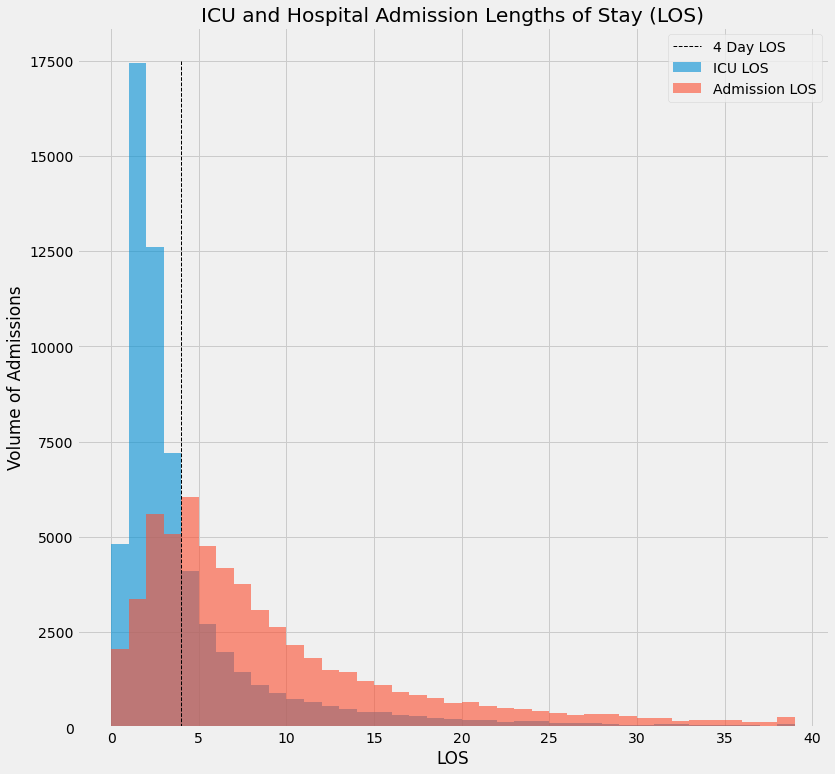

In [9]:
bins = list(range(40))
fig, ax = plt.subplots(figsize = (12,12))
ax.hist(los_data['icu_los'],bins=bins, label='ICU LOS', alpha=.6)
ax.hist(los_data['adm_los'], bins = bins, label='Admission LOS', alpha=.6)
ax.plot([4,4], [0,17500], '--k', linewidth = 1, label='4 Day LOS')
ax.set_title('ICU and Hospital Admission Lengths of Stay (LOS)')
ax.set_xlabel('LOS')
ax.set_ylabel('Volume of Admissions')
ax.legend()


In [10]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(sparse=False)
hot_codes = enc.fit_transform(baseline[['admission_type','first_careunit']])
hot_names = enc.get_feature_names()
baseline[hot_names] = hot_codes

In [11]:
baseline['admit_time_ym'] = baseline['admittime'].dt.strftime('%Y-%m')
baseline['admit_time_m'] = baseline['admittime'].dt.strftime('%m').astype('int')

In [12]:
annual_time = baseline[['hadm_id', 'admit_time_ym', 'death_in_hosp', 'death_4_days']].groupby('admit_time_ym').agg({'hadm_id':'count', 'death_in_hosp':'sum','death_4_days':'sum'})
month_time = baseline[['hadm_id', 'admit_time_m', 'death_in_hosp', 'death_4_days']].groupby('admit_time_m').agg({'hadm_id':'count', 'death_in_hosp':'sum','death_4_days':'sum'})

In [13]:
month_time['dh_rate'] = month_time['death_in_hosp'] / month_time['hadm_id']
month_time['dhfour_rate'] = month_time['death_4_days'] / month_time['hadm_id']

Text(0, 0.5, 'Mortality Rate (deaths per admission)')

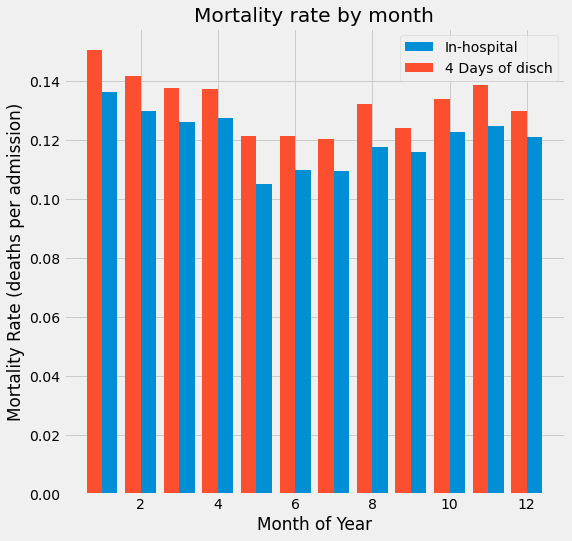

In [14]:
fig, ax = plt.subplots(figsize=(8,8))
ax.bar(x=month_time.index, height = month_time['dh_rate'], label='In-hospital', width=.4, align='edge')
ax.bar(x=month_time.index, height = month_time['dhfour_rate'], label='4 Days of disch', width=-.4, align='edge')
ax.legend()
ax.set_title('Mortality rate by month')
ax.set_xlabel('Month of Year')
ax.set_ylabel('Mortality Rate (deaths per admission)')

In [15]:
baseline['age_deci'] = (baseline['age_'] / 10).astype('int')

In [16]:
age_dr = baseline[['hadm_id', 'age_deci', 'death_in_hosp', 'death_4_days' ]].groupby('age_deci').agg({'hadm_id':'count', 'death_in_hosp':'sum','death_4_days':'sum'})
age_dr['dh_rate'] = age_dr['death_in_hosp'] / age_dr['hadm_id']
age_dr['dhfour_rate'] = age_dr['death_4_days'] / age_dr['hadm_id']

Text(0, 0.5, 'Mortality Rate (deaths per admission)')

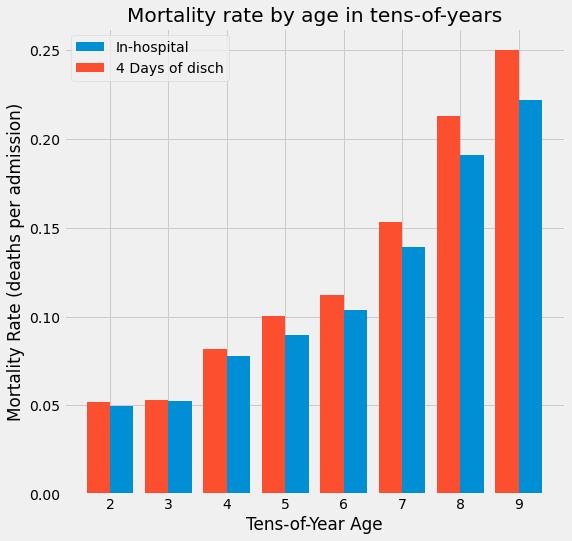

In [17]:
fig, ax = plt.subplots(figsize=(8,8))
ax.bar(x=age_dr.index, height = age_dr['dh_rate'], label='In-hospital', width=.4, align='edge')
ax.bar(x=age_dr.index, height = age_dr['dhfour_rate'], label='4 Days of disch', width=-.4, align='edge')
ax.legend()
ax.set_title('Mortality rate by age in tens-of-years')
ax.set_xlabel('Tens-of-Year Age')
ax.set_ylabel('Mortality Rate (deaths per admission)')

In [18]:
X = baseline.iloc[:,7:].drop(['admit_time_ym','death_in_hosp'], axis=1)
y = X.pop('death_4_days')

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 18, shuffle=True, stratify=y)

In [20]:
def plot_folds_model_roc(model, cv, model_title, X, y, get_tpr=0):
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0,1,100)
    fig, ax = plt.subplots(figsize=(10,10))

    for i, (train, test) in enumerate(cv.split(X.values, y.values)):
        model.fit(X.values[train,:], y.values[train])
        viz = plot_roc_curve(model, X.values[test,:], y.values[test], name=f'ROC fold {i}', alpha = .3, lw=1, ax=ax)
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
            label='Chance', alpha=.8)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
            label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
            lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')

    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
           title="Receiver operating characteristic - " + model_title)
    ax.legend(loc="lower right")
    plt.show()
    if get_tpr == 1:
        return mean_tpr


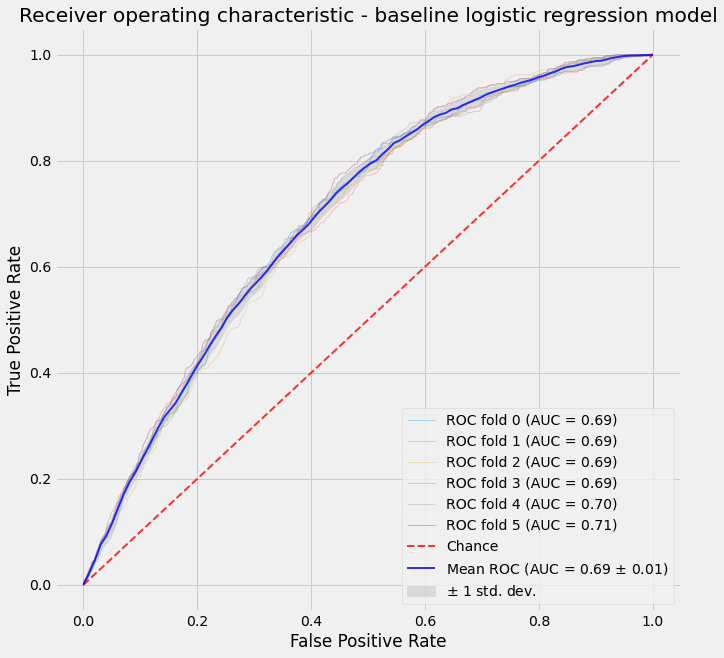

In [21]:
tprs = {}
cv = KFold(n_splits=6, shuffle = True)
class_model = LogisticRegression(solver='lbfgs', max_iter = 1500)
tprs['baseline'] = plot_folds_model_roc(class_model, cv, 'baseline logistic regression model', X_train, y_train,1)
#baseline has month, gender, admission type, first care unit, and if the visit was a readmission 


Text(0, 0.5, 'Trig result')

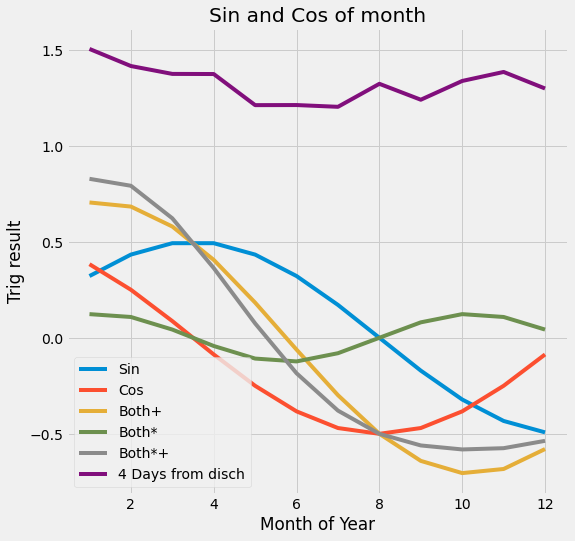

In [22]:
shift = 1
squish = .5
stretch = 1.5
s = squish * np.sin((month_time.index + shift) * 2*np.pi/(12*stretch))
c = squish * np.cos((month_time.index + shift) * 2*np.pi/(12*stretch))

fig, ax = plt.subplots(figsize=(8,8))
ax.plot(month_time.index, s, label='Sin')
ax.plot(month_time.index, c, label='Cos')
ax.plot(month_time.index, s+c, label='Both+')
ax.plot(month_time.index, s*c, label='Both*')
ax.plot(month_time.index, s + c + s*c, label='Both*+')
ax.plot(month_time.index, month_time['dhfour_rate']*10, label='4 Days from disch')
ax.legend()
ax.set_title('Sin and Cos of month')
ax.set_xlabel('Month of Year')
ax.set_ylabel('Trig result')

In [23]:
baseline.columns

Index(['subject_id', 'hadm_id', 'age_', 'gender', 'admittime',
       'admission_type', 'first_careunit', 'readmit_thirty', 'death_in_hosp',
       'death_4_days', 'gender_bin', 'x0_ELECTIVE', 'x0_EMERGENCY',
       'x0_URGENT', 'x1_CCU', 'x1_CSRU', 'x1_MICU', 'x1_SICU', 'x1_TSICU',
       'admit_time_ym', 'admit_time_m', 'age_deci'],
      dtype='object')

In [24]:
model_elements = ['readmit_thirty','death_4_days', 'gender_bin', 'x0_ELECTIVE', 'x0_EMERGENCY',
       'x0_URGENT', 'x1_CCU', 'x1_CSRU', 'x1_MICU', 'x1_SICU', 'x1_TSICU', 'admit_time_m', 'age_deci']
v_zero = baseline[model_elements].copy()

In [25]:
shift = 1
squish = .5
stretch = 1.5
s = squish * np.sin((v_zero['admit_time_m'].copy() + shift) * 2*np.pi/(12*stretch))
c = squish * np.cos((v_zero['admit_time_m'].copy() + shift) * 2*np.pi/(12*stretch))
v_zero['admit_time_m'] = s*c

In [26]:
y_zero = v_zero.pop('death_4_days')
X_zero = v_zero.copy()

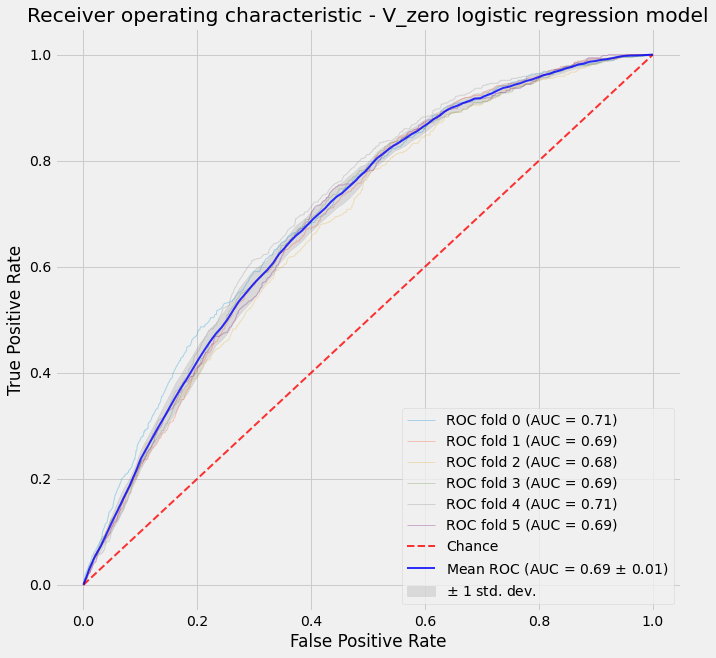

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X_zero, y_zero, test_size = .25, random_state = 18, shuffle=True, stratify=y)
cv = KFold(n_splits=6, shuffle = True)
class_model = LogisticRegression(solver='lbfgs', max_iter=1500)
tprs['v_0'] = plot_folds_model_roc(class_model, cv, 'V_zero logistic regression model', X_train, y_train, 1)
#V_0 has transformation of admit month via sin/cosine

In [28]:
filepath = './src/v_one_data_set_extraction.sql'
v_one = data_extraction(filepath, conn)


In [29]:
id_cols = ['subject_id', 'hadm_id']
month_col = ['admit_time_m']
age_col = ['age_']
cols_for_encoding = ['admission_type', 'first_careunit', 'insurance', 'relig', 'marital']

month_transform(v_one, month_col)

hot_coding(v_one, cols_for_encoding)

age_bands(v_one, age_col, 10)

y_one = v_one.pop('death_4_days')
X_one = v_one.copy()
X_one.drop(cols_for_encoding, axis=1, inplace=True)
X_one.drop(month_col, axis=1, inplace=True)
X_one.drop(age_col, axis=1, inplace=True)
X_one.drop(id_cols, axis=1, inplace=True)

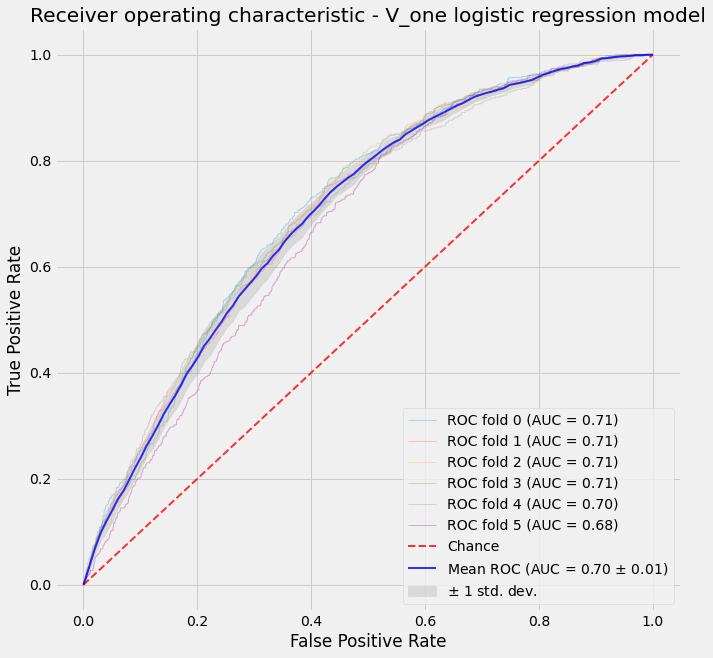

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X_one, y_one, test_size = .25, random_state = 18, shuffle=True, stratify=y)
cv = KFold(n_splits=6, shuffle = True)
class_model = LogisticRegression(solver='lbfgs', max_iter=1500)
tprs['v_1'] = plot_folds_model_roc(class_model, cv, 'V_one logistic regression model', X_train, y_train, 1)
#V_1 adds marital status, insurance, and religion

In [31]:
filepath = './src/v_two_data_set_extraction.sql'
v_two = data_extraction(filepath, conn)

In [32]:
id_cols = ['subject_id', 'hadm_id']
month_col = ['admit_time_m']
age_col = ['age_']
cols_for_encoding = ['admission_type', 'first_careunit', 'insurance', 'relig', 'marital']

month_transform(v_two, month_col)

hot_coding(v_two, cols_for_encoding)

age_bands(v_two, age_col, 10)

y_two = v_two.pop('death_4_days')
X_two = v_two.copy()
X_two.drop(cols_for_encoding, axis=1, inplace=True)
X_two.drop(month_col, axis=1, inplace=True)
X_two.drop(age_col, axis=1, inplace=True)
X_two.drop(id_cols, axis=1, inplace=True)

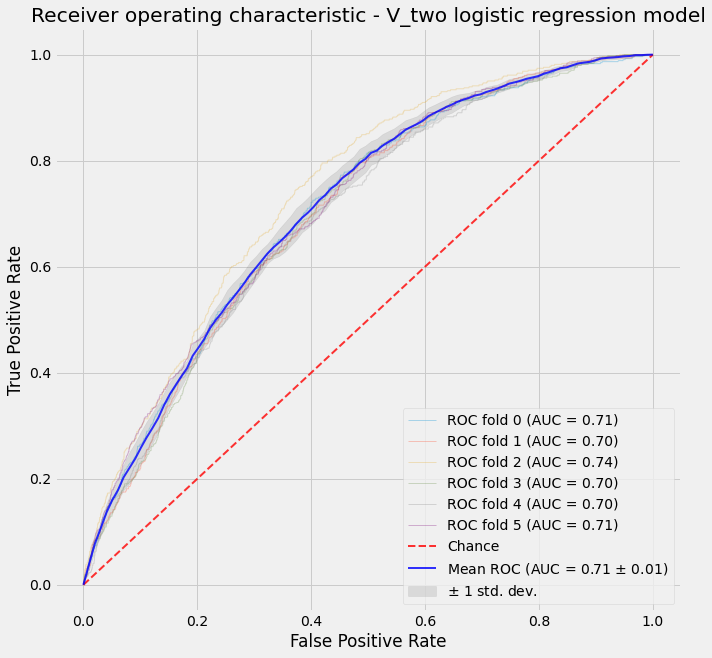

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X_two, y_two, test_size = .25, random_state = 18, shuffle=True, stratify=y)
cv2 = KFold(n_splits=6, shuffle = True)
class_model2 = LogisticRegression(solver='lbfgs', max_iter=1500)
tprs['v_2'] = plot_folds_model_roc(class_model2, cv2, 'V_two logistic regression model', X_train, y_train, 1)
#V_2 adds chronic markers as separate values



In [34]:
X_two.columns

Index(['gender', 'readmit_thirty', 'cirrhosis', 'hiv', 'immuno_def',
       'hep_fail', 'blood_cncr', 'metastatic_cncr', 'admit_month_transform',
       'x0_ELECTIVE', 'x0_EMERGENCY', 'x0_URGENT', 'x1_CCU', 'x1_CSRU',
       'x1_MICU', 'x1_SICU', 'x1_TSICU', 'x2_Government', 'x2_Medicaid',
       'x2_Medicare', 'x2_Private', 'x2_Self Pay', 'x3_RELIGIOUS',
       'x3_RELIGIOUS_NOT_SPEC', 'x3_RELIGIOUS_NO_MED', 'x4_OTHER',
       'x4_PARTNERED', 'x4_SINGLE', 'x4_WIDOWED', 'age_deci'],
      dtype='object')

In [35]:
X_two['chronic'] = X_two[['cirrhosis', 'hiv', 'immuno_def',
       'hep_fail', 'blood_cncr', 'metastatic_cncr']].sum(axis=1)

In [36]:
X_two['chronic'] = X_two[['cirrhosis', 'hiv', 'immuno_def',
       'hep_fail', 'blood_cncr', 'metastatic_cncr']].sum(axis=1)
X_twohalf= X_two.drop(['cirrhosis', 'hiv', 'immuno_def',
       'hep_fail', 'blood_cncr', 'metastatic_cncr'], axis = 1, inplace=False)

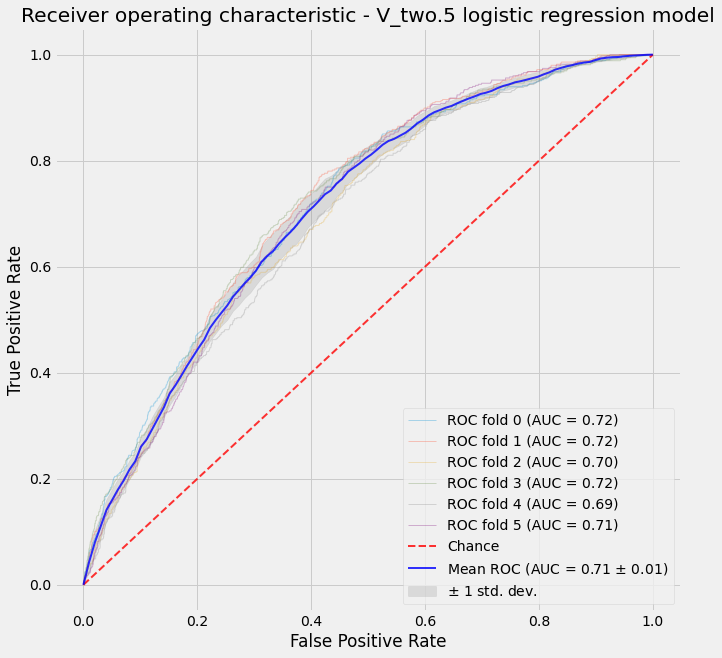

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X_two, y_two, test_size = .25, random_state = 18, shuffle=True, stratify=y)
cv2_5 = KFold(n_splits=6, shuffle = True)
class_model2_5 = LogisticRegression(solver='lbfgs', max_iter=1500)
tprs['v_2_5'] = plot_folds_model_roc(class_model2_5, cv2_5, 'V_two.5 logistic regression model', X_train, y_train, 1)
#V_2.5 adds sum column of chronic markers

In [38]:
filepath = './src/avg_lab_value_daily.sql'
admit_labs = data_extraction(filepath, conn)

In [39]:
#admit_labs.describe().T

In [40]:
norm_ranges = {
    'aniongap':[3,10], 
    'albumin':[3.5,5.5], 
    'bilirubin':[.3,1.2], 
    'creatinine':[.7,1.3], 
    'glucose':[100,200], 
    'hematocrit':[36,51],
    'hemoglobin':[12,17], 
    'lactate':[6,16], 
    'platelet':[150,350],
    'sodium':[136,145], 
    'bun':[8,20], 
    'wbc':[4.0,10.0]
}



In [41]:
def lab_val_scale(val, rng):
    norm_width = rng[1] - rng[0]
    sign = 1
    if val > rng[1]:
        diff = val - rng[1]
    elif val < rng[0]:
        diff = rng[0] - val
        sign = -1
    else:
        diff = 0
    return sign * ((diff / norm_width)**2)

def transform_labs(df,norm_ranges):
    for lab, rng in norm_ranges.items():
        df[lab] = df[lab].apply(lab_val_scale, args=(rng,))
        

In [42]:
transform_labs(admit_labs, norm_ranges)


In [43]:
filepath = './src/v_two_data_set_extraction.sql'
v_three = data_extraction(filepath, conn)

In [44]:
id_cols = ['subject_id', 'hadm_id']
month_col = ['admit_time_m']
age_col = ['age_']
cols_for_encoding = ['admission_type', 'first_careunit', 'insurance', 'relig', 'marital']

month_transform(v_three, month_col)
hot_coding(v_three, cols_for_encoding)
age_bands(v_three, age_col, 10)
v_three['chronic'] = v_three[['cirrhosis', 'hiv', 'immuno_def',
       'hep_fail', 'blood_cncr', 'metastatic_cncr']].sum(axis=1)

v_three = v_three.merge(admit_labs, how='left', on=['subject_id', 'hadm_id'], suffixes=[None,"_y"])

y_three = v_three.pop('death_4_days')
X_three = v_three.copy()
X_three.drop(cols_for_encoding, axis=1, inplace=True)
X_three.drop(month_col, axis=1, inplace=True)
X_three.drop(age_col, axis=1, inplace=True)
X_three.drop(id_cols, axis=1, inplace=True)
X_three.drop(['cirrhosis', 'hiv', 'immuno_def',
       'hep_fail', 'blood_cncr', 'metastatic_cncr'], axis = 1, inplace=True)

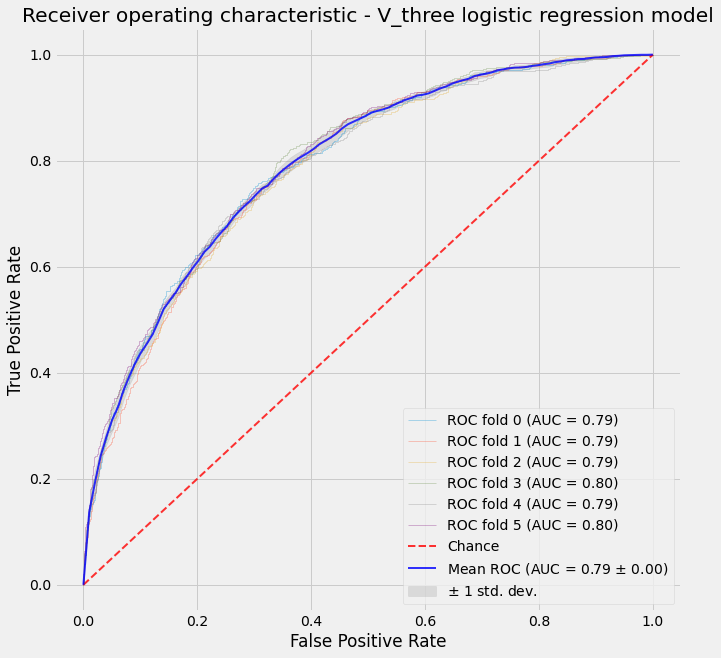

In [45]:
X_train3, X_test3, y_train3, y_test3 = train_test_split(X_three, y_three, test_size = .25, random_state = 18, shuffle=True, stratify=y)
cv3 = KFold(n_splits=6, shuffle = True)
class_model3 = LogisticRegression(solver='liblinear', max_iter=1500)
tprs['v_3'] = plot_folds_model_roc(class_model3, cv3, 'V_three logistic regression model', X_train3, y_train3, 1)
#V_3 adds lab values scaled for normal ranges

In [46]:
filepath = './src/train_lab_values.sql'
fourday_labs = data_extraction(filepath, conn)

In [47]:
transform_labs(fourday_labs, norm_ranges)

In [48]:
filepath = './src/v_two_data_set_extraction.sql'
v_four = data_extraction(filepath, conn)

In [49]:
id_cols = ['subject_id', 'hadm_id']
month_col = ['admit_time_m']
age_col = ['age_']
cols_for_encoding = ['admission_type', 'first_careunit', 'insurance', 'relig', 'marital']

month_transform(v_four, month_col)
hot_coding(v_four, cols_for_encoding)
age_bands(v_four, age_col, 10)
v_four['chronic'] = v_four[['cirrhosis', 'hiv', 'immuno_def',
       'hep_fail', 'blood_cncr', 'metastatic_cncr']].sum(axis=1)

v_four = v_four.merge(fourday_labs, how='left', on=['subject_id', 'hadm_id'], suffixes=[None,"_y"])


y_four = v_four.pop('death_4_days')
X_four = v_four.copy()
X_four.drop(cols_for_encoding, axis=1, inplace=True)
X_four.drop(month_col, axis=1, inplace=True)
X_four.drop(age_col, axis=1, inplace=True)
X_four.drop(id_cols, axis=1, inplace=True)
X_four.drop(['cirrhosis', 'hiv', 'immuno_def',
       'hep_fail', 'blood_cncr', 'metastatic_cncr'], axis = 1, inplace=True)

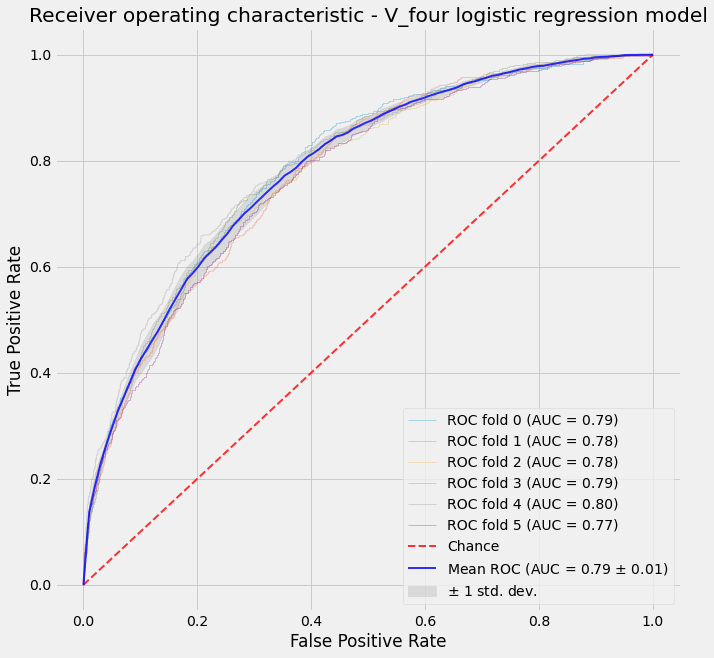

In [50]:
X_train4, X_test4, y_train4, y_test4 = train_test_split(X_four, y_four, test_size = .25, random_state = 18, shuffle=True, stratify=y)
cv4 = KFold(n_splits=6, shuffle = True)
class_model4 = LogisticRegression(solver='liblinear', max_iter=1500)
tprs['v_4'] = plot_folds_model_roc(class_model4, cv4, 'V_four logistic regression model', X_train4, y_train4, 1)
#V_4 adds lab values scaled for normal ranges and based on 4 days out

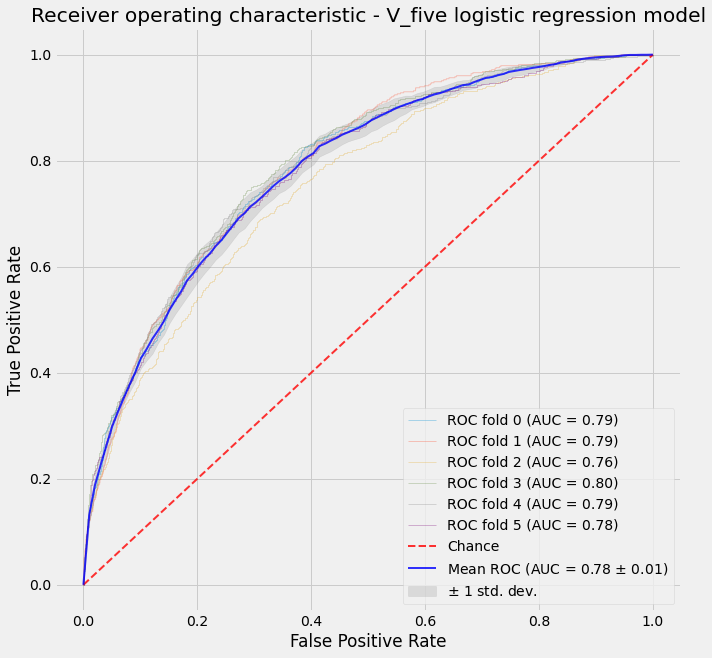

In [51]:
class_model5 = LogisticRegression(solver='liblinear', max_iter=1500, C=1.5)
tprs['v_5'] = plot_folds_model_roc(class_model5, cv4, 'V_five logistic regression model', X_train4, y_train4, 1)

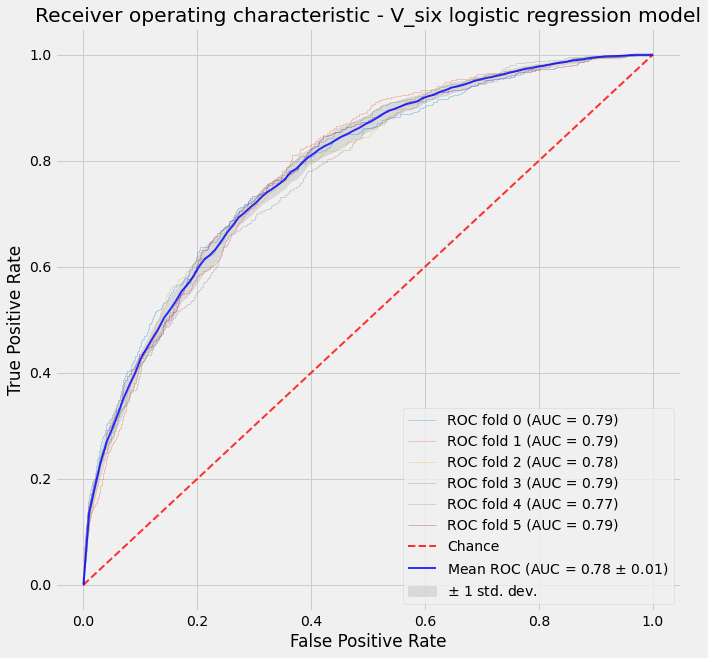

In [52]:
class_model6 = LogisticRegression(solver='liblinear', max_iter=1500, C=2)
tprs['v_6'] = plot_folds_model_roc(class_model6, cv4, 'V_six logistic regression model', X_train4, y_train4, 1)

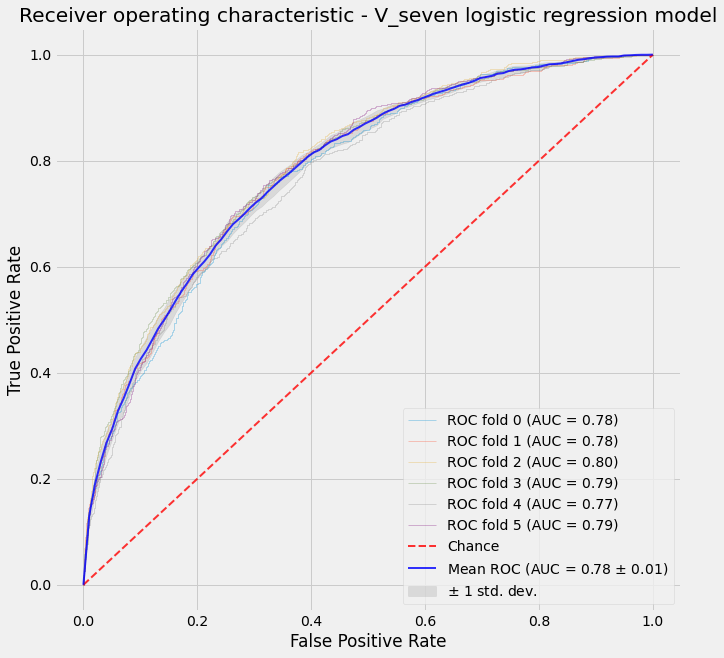

In [53]:
class_model7 = LogisticRegression(solver='liblinear', max_iter=1500, C=10)
tprs['v_7'] = plot_folds_model_roc(class_model7, cv4, 'V_seven logistic regression model', X_train4, y_train4, 1)

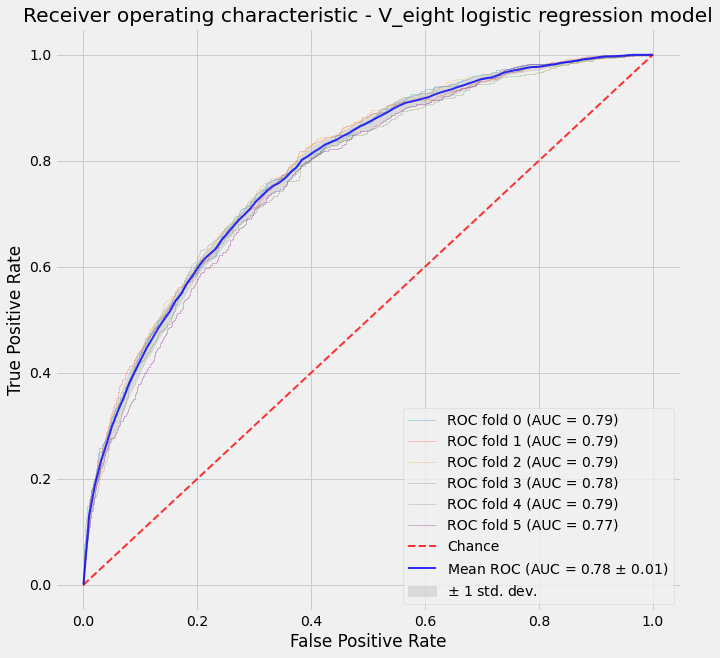

In [54]:
class_model8 = LogisticRegression(solver='liblinear', max_iter=1500, C=.6)
tprs['v_8'] = plot_folds_model_roc(class_model8, cv4, 'V_eight logistic regression model', X_train4, y_train4, 1)

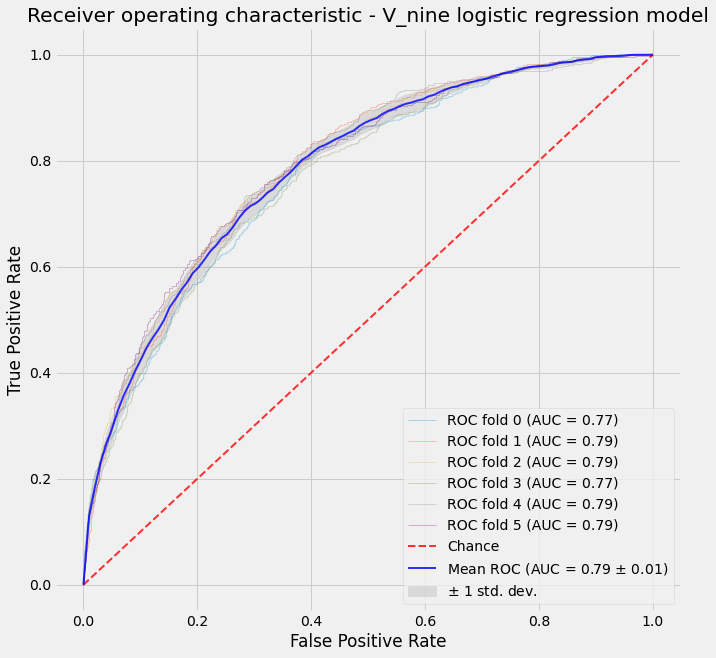

In [55]:
class_model9 = LogisticRegression(solver='liblinear', max_iter=1500, C=500)
tprs['v_9'] = plot_folds_model_roc(class_model9, cv4, 'V_nine logistic regression model', X_train4, y_train4, 1)

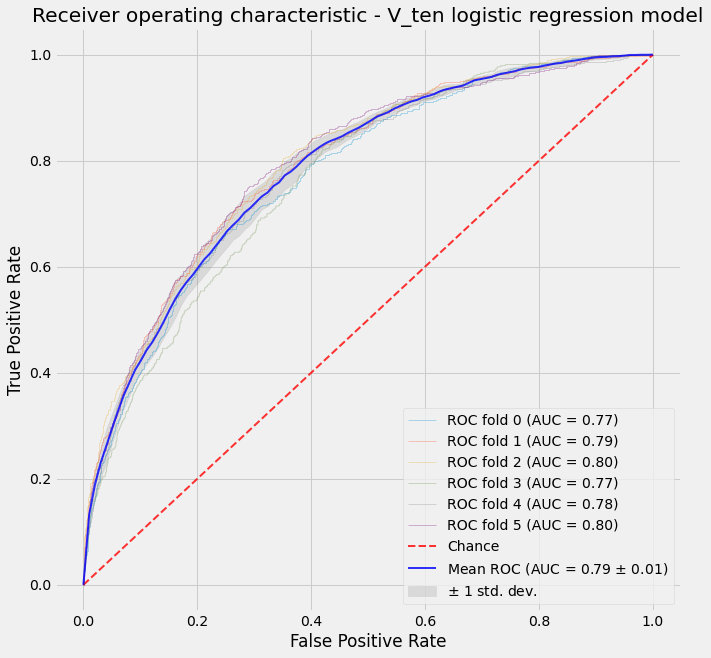

In [56]:
class_model10 = LogisticRegression(solver='liblinear', max_iter=1500, C=5000)
tprs['v_10'] = plot_folds_model_roc(class_model10, cv4, 'V_ten logistic regression model', X_train4, y_train4, 1)

In [57]:
tprs.keys()

dict_keys(['baseline', 'v_0', 'v_1', 'v_2', 'v_2_5', 'v_3', 'v_4', 'v_5', 'v_6', 'v_7', 'v_8', 'v_9', 'v_10'])

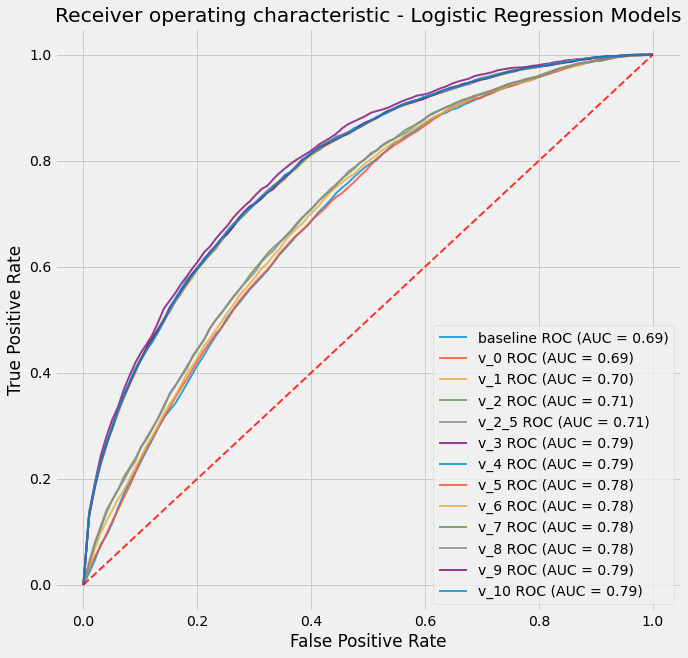

In [58]:
mean_fpr = np.linspace(0,1,100)
fig, ax = plt.subplots(figsize=(10,10))

for model, tpr in tprs.items():
    model_auc = auc(mean_fpr, tpr)
    ax.plot(mean_fpr, tpr, label=f'{model} ROC (AUC = {model_auc:0.2f})',
            lw=2, alpha=.8)
    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
           title="Receiver operating characteristic - Logistic Regression Models")
    ax.legend(loc="lower right")
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
plt.show()